In [1]:
# !jt -t monokai -ofs 10 -dfs 8 -cellw 90%

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import json
import re
import pathlib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [3]:
complexes = []
dir = "/media/hdd1/roproQ3drew"
dirs = os.listdir(dir)
for dr in dirs:
    if os.path.isdir(dir+'/'+dr):
        if re.search(r'\b\w{4}\b', dr):
            data = dir+'/'+dr+'/'+dr+"_TOTAL.json"
            if os.path.exists(data):
                complexes.append(dr)
print("we have Processed %d datasets"%len(complexes))                

we have Processed 101 datasets


In [4]:
df_total = pd.DataFrame()
for cmplx in complexes:
    df = pd.read_json(dir+'/'+cmplx+'/'+cmplx+'_TOTAL.json')
    df = df[df.complex != 1]    
    df = df[df.complex != 0] 
    df = df[df.ProQ3D > 0.0]
    df.reset_index(drop=True, inplace=True)
    df.loc[df.rmsd <= 1.0, 'docked'] = True
    df.loc[df.rmsd > 1, 'docked'] = False
    df2 = df[['docked']] 
    df.drop(['structure','method', 'zrank', 'name','H1_cluster', 'complex', 'rmsd', 'docked',
           'H1_distance', 'H1_sequence', 'H2_cluster', 'H2_distance', 'nres_all', 'ref',
           'H2_sequence', 'H3_cluster', 'H3_distance', 'H3_sequence', 'L1_cluster',
           'L1_distance', 'L1_sequence', 'L2_cluster', 'L2_distance',
           'L2_sequence', 'L3_cluster', 'L3_distance', 'L3_sequence'], axis=1, inplace=True)
    mm = MinMaxScaler()
    df_scaled = pd.DataFrame(mm.fit_transform(df),columns = df.columns)
    df2 = df2.join(df_scaled)
    df_total = df_total.append(df2, ignore_index=True)
    df_total.dropna(inplace=True)

In [5]:
df_total.docked = df_total.docked.astype(int)

In [6]:
corr_matrix = df_total.corr()
corr_matrix['docked'].sort_values(ascending=True)

dG_separated             -0.358670
dG_separated/dSASAx100   -0.299590
side1_score              -0.247186
side2_score              -0.245024
per_residue_energy_int   -0.238988
side1_normalized         -0.204538
side2_normalized         -0.196281
total_score              -0.180799
complex_normalized       -0.180799
fa_atr                   -0.173829
hbond_sc                 -0.150122
fa_elec                  -0.128322
hbond_lr_bb              -0.084287
hbond_bb_sc              -0.069458
fa_intra_rep             -0.058477
dslf_fa13                -0.027103
delta_unsatHbonds        -0.019820
p_aa_pp                  -0.019176
fa_intra_sol_xover4      -0.015448
fa_dun                   -0.011910
omega                    -0.000002
pro_close                 0.006828
rama_prepro               0.009208
ProQRosCenD               0.012472
hbond_sr_bb               0.017763
fa_rep                    0.025318
ProQ2D                    0.026042
ProQRosFAD                0.026724
hbond_E_fraction    

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_total, df_total['docked']):
    strat_train_set = df_total.loc[train_index]
    strat_test_set = df_total.loc[test_index]

In [8]:
print(strat_train_set.docked.value_counts()/ len(strat_train_set))
print(strat_test_set.docked.value_counts()/ len(strat_test_set))

0    0.95113
1    0.04887
Name: docked, dtype: float64
0    0.951411
1    0.048589
Name: docked, dtype: float64


In [9]:
X_train_prep = strat_train_set.drop("docked", axis=1)
y_train = strat_train_set["docked"].copy()
X_test_prep = strat_test_set.drop("docked", axis=1)
y_test = strat_test_set["docked"].copy()

X_train_prep.columns

Index(['ProQ2D', 'ProQRosCenD', 'ProQRosFAD', 'ProQ3D', 'complex_normalized',
       'dG_separated', 'dG_separated/dSASAx100', 'dSASA_hphobic', 'dSASA_int',
       'dSASA_polar', 'delta_unsatHbonds', 'hbond_E_fraction', 'hbonds_int',
       'nres_int', 'per_residue_energy_int', 'sc_value', 'side1_normalized',
       'side1_score', 'side2_normalized', 'side2_score', 'fa_atr', 'fa_rep',
       'fa_sol', 'fa_intra_rep', 'fa_intra_sol_xover4', 'lk_ball_wtd',
       'fa_elec', 'pro_close', 'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc',
       'hbond_sc', 'dslf_fa13', 'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity',
       'rama_prepro', 'total_score'],
      dtype='object')

In [10]:
X_train_prep.columns

Index(['ProQ2D', 'ProQRosCenD', 'ProQRosFAD', 'ProQ3D', 'complex_normalized',
       'dG_separated', 'dG_separated/dSASAx100', 'dSASA_hphobic', 'dSASA_int',
       'dSASA_polar', 'delta_unsatHbonds', 'hbond_E_fraction', 'hbonds_int',
       'nres_int', 'per_residue_energy_int', 'sc_value', 'side1_normalized',
       'side1_score', 'side2_normalized', 'side2_score', 'fa_atr', 'fa_rep',
       'fa_sol', 'fa_intra_rep', 'fa_intra_sol_xover4', 'lk_ball_wtd',
       'fa_elec', 'pro_close', 'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc',
       'hbond_sc', 'dslf_fa13', 'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity',
       'rama_prepro', 'total_score'],
      dtype='object')

In [11]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train_prep)
X_test = ss.fit_transform(X_test_prep)
y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)


In [12]:
from sklearn import svm

In [13]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(X_train, y_train_1)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
from sklearn.model_selection import cross_val_score

In [15]:
cross_val_score(clf, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.98172324, 0.97650131, 0.97780679, 0.97908497, 0.95816993,
       0.96470588, 0.96862745, 0.97254902, 0.96862745, 0.9751634 ])

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
cross_val_score(sgd_clf, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.97127937, 0.97519582, 0.96605744, 0.96601307, 0.95686275,
       0.96078431, 0.96078431, 0.95424837, 0.96862745, 0.97254902])

In [18]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3)

# for train_index, test_index in skfolds.split(X_train, y_train_1):
#     clone_clf = clone(clf)
#     X_train_folds = X_train[train_index]
#     y_train_folds = y_train_1[train_index]
#     X_test_fold = X_train[test_index]
#     y_test_fold = y_train_1[test_index]

#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct / len(y_pred))

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train_1, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

array([[7217,   62],
       [ 159,  215]])

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)

0.776173285198556

In [22]:
recall_score(y_train_1, y_train_pred)

0.5748663101604278

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3,
                             method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

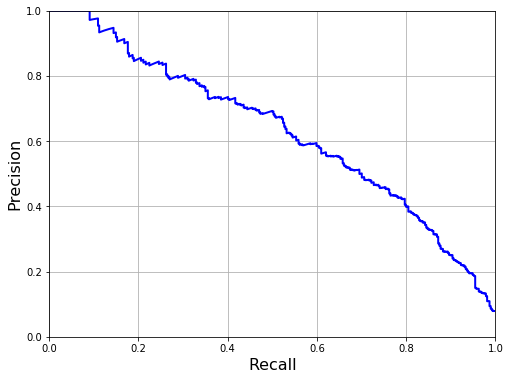

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6), facecolor="white")
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)

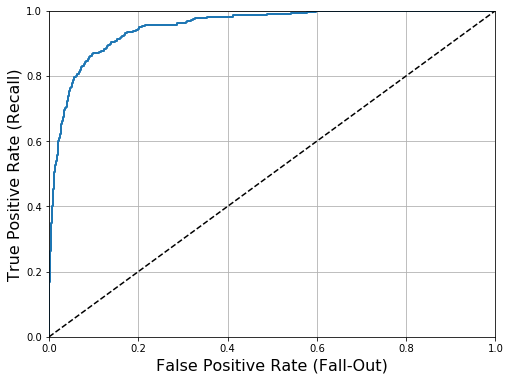

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6), facecolor="white")                         # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_1, y_scores)

0.9519223493266469

In [29]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")

In [30]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1, y_scores_forest)

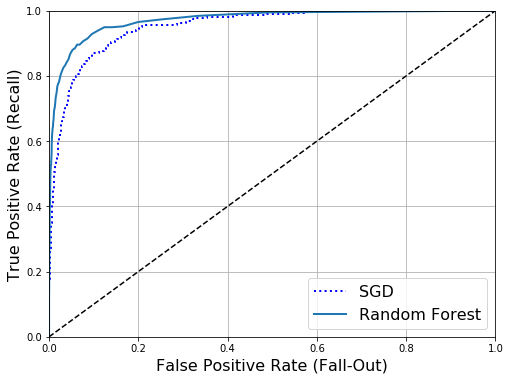

In [31]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [32]:
roc_auc_score(y_train_1, y_scores_forest)

0.9712103090496212

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

/home/drewaight/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [34]:
xgb_clf = XGBClassifier(objective= 'binary:logistic', nthread=16, seed=42)
xgb_clf.fit(X_train, y_train_1)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [35]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [36]:
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [37]:
# grid_search.fit(X_train, y_train)

In [38]:
# final_xgb = grid_search.best_estimator_

In [39]:
import pickle
final_xgb_loaded = pickle.load(open("final_xgb.dat", "rb"))

In [40]:
cross_val_score(final_xgb_loaded, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.98172324, 0.98563969, 0.98302872, 0.97385621, 0.97908497,
       0.97124183, 0.97777778, 0.97124183, 0.97777778, 0.98169935])

In [41]:
print(final_xgb_loaded)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


In [42]:
feature_importances = final_xgb_loaded.feature_importances_

sorted(zip(feature_importances, list(df)), reverse=True)

[(0.123975456, 'dSASA_hphobic'),
 (0.036239885, 'nres_int'),
 (0.03144727, 'sc_value'),
 (0.02704473, 'ProQRosCenD'),
 (0.017870482, 'dslf_fa13'),
 (0.017170971, 'hbond_lr_bb'),
 (0.016983602, 'dG_separated'),
 (0.016795868, 'side2_score'),
 (0.01642651, 'hbonds_int'),
 (0.015799427, 'ProQ2D'),
 (0.015533878, 'dSASA_int'),
 (0.0152108725, 'total_score'),
 (0.0135755725, 'side1_normalized'),
 (0.01306303, 'ProQRosFAD'),
 (0.013013343, 'fa_rep'),
 (0.012980848, 'dSASA_polar'),
 (0.01264038, 'omega'),
 (0.012231643, 'fa_intra_sol_xover4'),
 (0.011984855, 'side1_score'),
 (0.011740401, 'complex_normalized'),
 (0.011678313, 'hbond_E_fraction'),
 (0.011483704, 'dG_separated/dSASAx100'),
 (0.011370855, 'delta_unsatHbonds'),
 (0.009912839, 'fa_elec'),
 (0.008726402, 'per_residue_energy_int'),
 (0.008675906, 'hbond_sc'),
 (0.008617207, 'ProQ3D'),
 (0.008364862, 'fa_atr'),
 (0.008310698, 'pro_close'),
 (0.008071253, 'hbond_sr_bb'),
 (0.0071185, 'hbond_bb_sc'),
 (0.0067962096, 'yhh_planarity'),
 

In [43]:
# cvres = grid_search.cv_results_
# # for key, value in grid_search.cv_results_.items() :
# #     print (key)

# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

In [44]:
y_probas_xgb = cross_val_predict(final_xgb_loaded, X_train, y_train_1, cv=3,
                                 method="predict_proba")

In [45]:
y_scores_xgb = y_probas_xgb[:, 1] # score = proba of positive class
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train_1, y_scores_xgb)

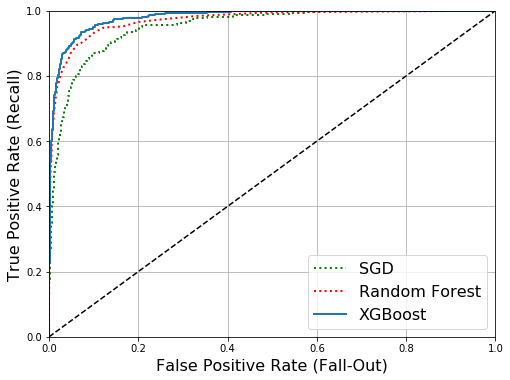

In [46]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr, tpr, "g:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, "r:", linewidth=2, label="Random Forest")
plot_roc_curve(fpr_xgb, tpr_xgb, "XGBoost")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [47]:
train_roc = roc_auc_score(y_train_1, y_scores_xgb)

In [48]:
y_probas_xgb_test = cross_val_predict(final_xgb_loaded, X_test, y_test, cv=3,
                                     method="predict_proba")

In [49]:
y_scores_xgb_test = y_probas_xgb_test[:, 1] # score = proba of positive class
fpr_xgb_t, tpr_xgb_t, thresholds_xgb_t = roc_curve(y_test, y_scores_xgb_test)

In [50]:
test_roc = roc_auc_score(y_test, y_scores_xgb_test)

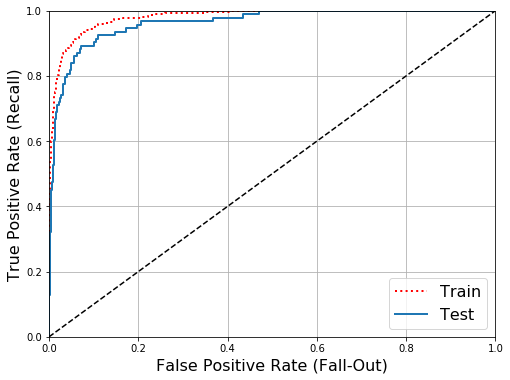

In [51]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr_xgb, tpr_xgb, "r:", linewidth=2, label="Train")
plot_roc_curve(fpr_xgb_t, tpr_xgb_t, "Test")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

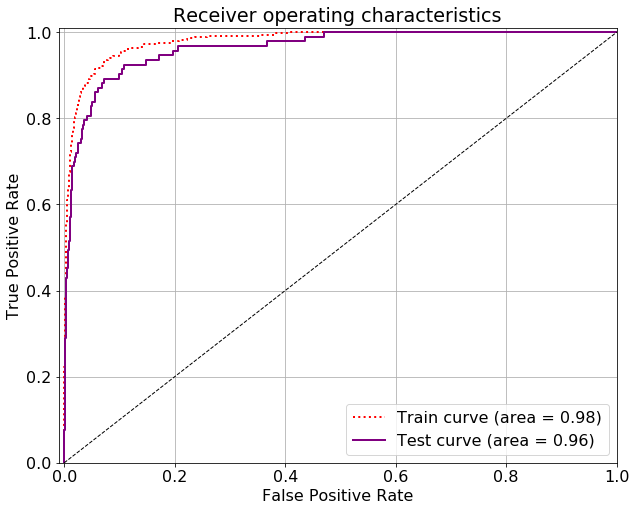

In [57]:
plt.figure(figsize=(10, 8), facecolor="white")
lw = 2
plt.grid(True)
plt.plot(fpr_xgb, tpr_xgb, "r:",
         lw=lw, label='Train curve (area = %0.2f)' % train_roc)
plt.plot(fpr_xgb_t, tpr_xgb_t, color="Purple",
         lw=lw, label='Test curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 16})
plt.show()